In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display

In [28]:
OUT_STEPS = 4
NUM_FEATURES = 9

In [19]:

def data_process(origin_df, train_size=0.7, val_size = 0.2):
    """Deal with the data, transform the date to compute sin/cos features to capture the cyclical nature of the date.

    Args:
        df (_dataframe_): with columns ['period_end_date', 'followers', 'likes', 'comments', 'videos', 'pictures'] without NA values, the data are belong to one brand.
    Returns:
        train_df (_dataframe_): the training data
        val_df (_dataframe_): the validation data
        test_df (_dataframe_): the test data
        num_features (int): the number of features in the data
    """
    df = origin_df.copy()
    n = len(df)
    
    # create new rows to predict
    # last_date = pd.to_datetime(df['period_end_date'].iloc[-1], format='%Y-%m-%d')
    # for i in range(label_size):
    #     new_date = last_date + pd.DateOffset(days=7)
    #     # the new row with the new date, other columns are 0
    #     # transform the date to string
    #     new_date = new_date.strftime('%Y-%m-%d')
    #     new_row = pd.DataFrame([[new_date, 0, 0, 0, 0, 0]], columns=df.columns)
    #     df = pd.concat([df, new_row], ignore_index=True)
        
    date = pd.to_datetime(df.pop('period_end_date'), format='%Y-%m-%d')
    
    # for i in range(label_size):
    #     # add new date to date
    #     date = date.append(pd.Series(date + pd.DateOffset(days=7*(i+1))))
    #     # add new data to df filling with 0
    # df = df.append(pd.DataFrame(np.zeros((label_size, df.shape[1])), columns=df.columns))
    
    # comput the sin/cosine of the month, and year
    df['month_sin'] = date.dt.month.apply(lambda x: np.sin(2 * np.pi * x / 12))
    df['month_cos'] = date.dt.month.apply(lambda x: np.cos(2 * np.pi * x / 12))
    df['year_sin'] = date.dt.isocalendar().week.apply(lambda x: np.sin(2 * np.pi * x / 52))
    df['year_cos'] = date.dt.isocalendar().week.apply(lambda x: np.cos(2 * np.pi * x / 52))

    # split the data into train and test
    #column_indices = {name: i for i, name in enumerate(df.columns)}
    
    train_size = 0.7
    val_size = 0.2
    train_df = df[0:int(n*train_size)]
    val_df = df[int(n*train_size):int(n*(train_size+val_size))]
    test_df = df[int(n*(train_size+val_size)):]
    #pred_df = df[n:]
    num_features = df.shape[1]
        
    # normalize the data 
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    return train_df, val_df, test_df, num_features


In [30]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def plot(self, model=None, plot_col='change in followers', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('week')
    return predictions
    
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  def make_pred_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def pred(self):
    return self.make_pred_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      #result = next(iter(self.train))
      # No example batch was found, then get the last one from the `.eval` dataset
      result = next(iter(self.pred))
      # And cache it for next time
      self._example = result
    return result

In [21]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
  
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

In [22]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(NUM_FEATURES)
  
  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state
  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step.
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output.
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

In [35]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

def plot_MAE(performance, val_performance):
    x = np.arange(len(performance))
    width = 0.3

    metric_name = 'mean_absolute_error'
    val_mae = [v[metric_name] for v in val_performance.values()]
    test_mae = [v[metric_name] for v in performance.values()]

    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=performance.keys(),
            rotation=45)
    plt.ylabel('MAE (average over all outputs)')
    _ = plt.legend()

def train_eval_model(df, pred_step=4):
    """train all the models for the brand's data and evaluate the performance of the models

    Args:
        df (dataframe): the data of the brand, columns=['period_end_date', 'followers', 'likes', 'comments', 'videos', 'pictures']
        pred_step (int, optional): the number of weeks in future. Defaults to 1, meaning only predict the data for next week.

    Returns:
        best_model (tf.keras.Model): the best model name
        baseline (tf.keras.Model): the baseline model
        dense (tf.keras.Model): the dense model
        lstm_model (tf.keras.Model): the lstm model
        residual_lstm (tf.keras.Model): the residual lstm model
    """
    train_df, val_df, test_df, num_features = data_process(df)
    # set the global variable OUT_STEPS = pred_step
    global OUT_STEPS
    OUT_STEPS = pred_step
    multi_window = WindowGenerator(input_width=pred_step,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df, val_df=val_df, test_df=test_df)
    multi_val_performance = {}
    multi_performance = {}
        
    baseline = MultiStepLastBaseline()
    baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])
    baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])
    multi_val_performance['Baseline'] = baseline.evaluate(multi_window.val, return_dict=True)
    multi_performance['Baseline'] = baseline.evaluate(multi_window.test, verbose=0, return_dict=True)

    repeat_baseline = RepeatBaseline()
    repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
    multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
    
    multi_linear_model = tf.keras.Sequential([
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    
    

    history = compile_and_fit(multi_linear_model, multi_window)

    IPython.display.clear_output()
    multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
    multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
       
    multi_dense_model = tf.keras.Sequential([
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation='relu'),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(multi_dense_model, multi_window)

    IPython.display.clear_output()
    multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
    multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
        
    CONV_WIDTH = 3
    multi_conv_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1,  out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(multi_conv_model, multi_window)

    IPython.display.clear_output()

    multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
    multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
            
    multi_lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(multi_lstm_model, multi_window)

    IPython.display.clear_output()

    multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
    multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)

    feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
    prediction, state = feedback_model.warmup(multi_window.example[0])
    
    history = compile_and_fit(feedback_model, multi_window)

    IPython.display.clear_output()

    multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
    multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
                
    metric_name = 'mean_absolute_error'
    plot_MAE(multi_performance, multi_val_performance)
    
    best_model_name = None
    best_mae = float('inf')
    for name, value in multi_performance.items():
        if value[metric_name] < best_mae:
            best_model_name = name
            best_mae = value[metric_name]
        print(f'{name:15s}: {value[metric_name]:0.4f}')
    best_model = None
    if best_model_name == 'Baseline':
        best_model = baseline
    if best_model_name == 'Repeat':
        best_model = repeat_baseline
    if best_model_name == 'Linear':
        best_model = multi_linear_model
    if best_model_name == 'Dense':
        best_model = multi_dense_model
    if best_model_name == 'Conv':
        best_model = multi_conv_model
    if best_model_name == 'LSTM':
        best_model = multi_lstm_model
    if best_model_name == 'AR LSTM':
        best_model = feedback_model
    
    multi_window.plot(best_model)
    
    return best_model_name, best_model, multi_window
            
    

### DEMO

In [12]:
from utilities import *

In [13]:
df = clean_data()[0]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298040 entries, 0 to 298039
Data columns (total 7 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   period_end_date                         298040 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name  298040 non-null  object        
 2   followers                               236313 non-null  float64       
 3   pictures                                294176 non-null  float64       
 4   videos                                  288438 non-null  float64       
 5   comments                                293958 non-null  float64       
 6   likes                                   294288 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 15.9+ MB


In [15]:
df = derivatives_data(df)[0]
df.dropna(inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231658 entries, 21 to 298039
Data columns (total 7 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   period_end_date                         231658 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name  231658 non-null  object        
 2   change in pictures                      231658 non-null  float64       
 3   change in videos                        231658 non-null  float64       
 4   change in comments                      231658 non-null  float64       
 5   change in likes                         231658 non-null  float64       
 6   change in followers                     231658 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 14.1+ MB


In [17]:
df_versace = df[df['business_entity_doing_business_as_name'] == 'Versace'].drop(columns=['business_entity_doing_business_as_name'])
df_versace.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455 entries, 283298 to 283752
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   period_end_date      455 non-null    datetime64[ns]
 1   change in pictures   455 non-null    float64       
 2   change in videos     455 non-null    float64       
 3   change in comments   455 non-null    float64       
 4   change in likes      455 non-null    float64       
 5   change in followers  455 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 24.9 KB


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6316 - mean_absolute_error: 0.4678 
Baseline       : 0.7124
Repeat         : 1.0642
Linear         : 0.6068
Dense          : 0.4429
Conv           : 0.4112
LSTM           : 0.3684
AR LSTM        : 0.3892


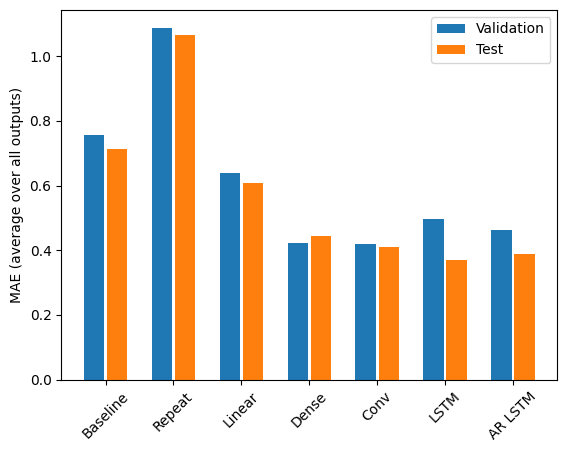

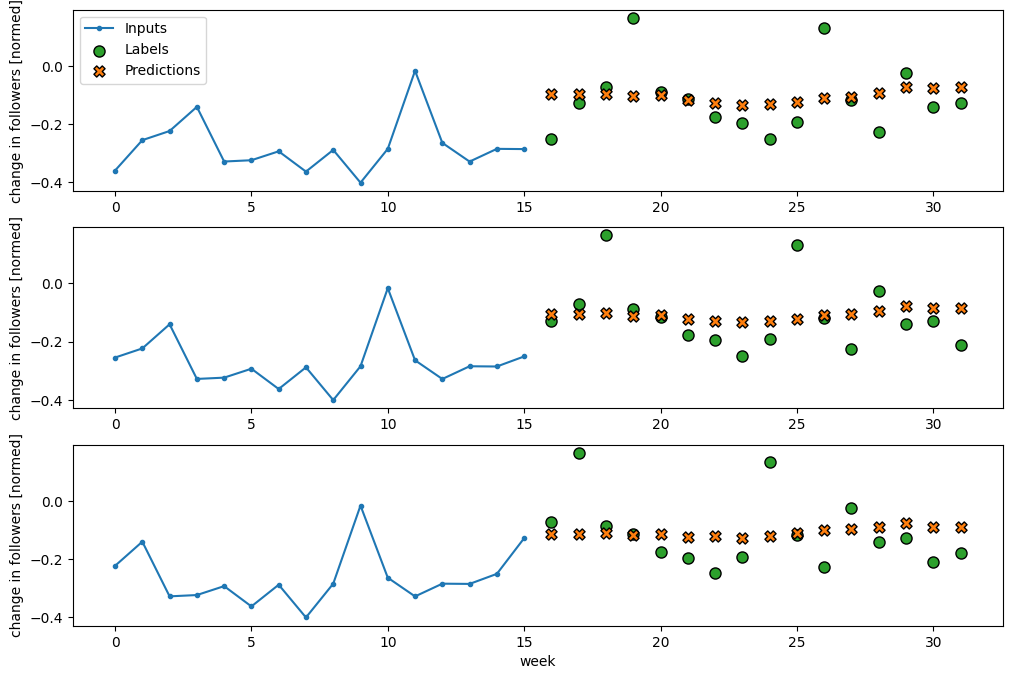

In [42]:
best_model_name, best_model, window = train_eval_model(df_versace, pred_step=16)